## Toy MHD and divergence cleaning 


We made a code to check the divergence cleaning strategies discussed in: https://www.overleaf.com/read/phmtkqtkxwjr#baf932

In this version we add the hyperbolic divergence cleaning. Since we are using periodic boundary conditions we don't expect much improvement, because the waves will revolve around,  only the one coming from the damping term. 


### The evolution equations are:

$$
\partial_t B^i = \nabla_j (v^j B^i - v^i B^j) + \kappa \nabla^i (\nabla_j B^j)
$$
for the parabolic case, and

\begin{align*}
\partial_t B^i &= \nabla_j (v^j B^i - v^i B^j) + \nabla^i ψ \\
\partial_t ψ &= c^2 \nabla_j B^j - τψ
\end{align*}


In [1]:
using Plots
using SummationByPartsOperators
using LinearAlgebra
using ArraysOfArrays
using Base.Threads
using Revise
using JLD2
import Pkg; Pkg.add("WriteVTK")
using WriteVTK

includet("../PIC/PIC-1D/aux_functions/aux_functions_grid.jl")
includet("../PIC/PIC-1D/aux_functions/aux_functions_E-B.jl")
includet("../PIC/PIC-1D/aux_functions/aux_functions_RHS.jl")
includet("toy_MHD_auxfunctions.jl")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
Precompiling project...
           ✗ GLMakie
  0 dependencies successfully precompiled in 17 seconds. 890 already precompiled.

The following 1 direct dependency failed to precompile:

GLMakie 

Failed to precompile GLMakie [e9467ef8-e4e7-5192-8a1a-b1aee30e663a] to "/users/oreula/.julia/compiled/v1.11/GLMakie/jl_Kke3Pp".
┌ Warning:     OpenGL/GLFW wasn't loaded correctly or couldn't be initialized.
│     This likely means, you're on a headless server without having OpenGL support setup correctly.
│     Have a look at the troubleshooting section in the readme:
│     https://github.com/MakieOrg/Makie.jl/tree/master/GLMakie#troubleshooting-opengl.
└ @ GLMakie ~/.julia/packages/GLMakie/6el3D/src/gl_backend.jl:4
ERROR: LoadError: InitError: Exception[GLFW.GLFWError(65550, "X11: The DISPLAY environment variable is missing"), ErrorException("g

Setting the box and the grid coordinates.

In [2]:
J = (200,250)
Box = (0.0,1.0,0.0,1.0)
dx = differentials(Box,J)
const D = 2

xv = [(i-1)*dx[1] for i in 1:J[1]]
yv = [(i-1)*dx[2] for i in 1:J[2]];

The finite differences. 

In [3]:
Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=4, xmin=Box[1], xmax=Box[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=4, xmin=Box[3], xmax=Box[4], N=J[2])
Δx = dissipation_operator(Dx;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
Δy = dissipation_operator(Dy;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
σx = 0.0 #dissipation strength
σy = 0.0 #dissipation strength

0.0

Build initial data and velocity field.

In [4]:

x0 = [0.5,0.5]
fv(x,y,k) = sin(k[1]*x)*sin(k[2]*y)
```
bump of radius r and smoothness p around the point x0
```
function fp(x,y,x0,r,p) 
    r20 = r^2
    r2 = (x-x0[1])^2+(y-x0[2])^2
    if r2 - r20 < 0
        return (r20 - r2)^p/r20^p
    else
        return 0.0
    end
end
```
gradient of bump of radius r and smoothness p around the point x0
```
function grad_fp(x,y,x0,r,p)
    r20 = r^2
    r2 = (x-x0[1])^2+(y-x0[2])^2
    if r2 - r20 < 0
        return -2*p*[(x-x0[1]),(y-x0[2])]*(r20 - r2)^(p-1)/r20^p
    else
        return [0.0, 0.0]
    end
end

function polynomial_bump(x,y,p)
    return x^p*(x-1)^p*y^p*(y-1)^p*2^4p
end

#possible V's 

# a sinusoidal one:
k1 = 2π*[1,1]
V = [-(l-2)*cos(k1[1]*xv[i]) + (l-1)*cos(k1[2]*yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];

# one from the gradient of a bump function. Because the CFL condition we don't want it to be too big.
#grad_Fp = [grad_fp(xv[i],yv[j],x0,0.45,8)[l] for l in 1:D, i in 1:J[1], j in 1:J[2]];
#V = -0.1*grad_Fp # with 0.1 it is about 1/2 at maximum. 

B = zeros(2,J[1],J[2]);
#possible B's
k2 = 2π*[2,2]
#B = [(l-2)*k2[2]*sin(k2[1]*xv[i])*cos(k2[2]*yv[j]) + (l-1)*k2[1]*cos(k2[1]*xv[i])*sin(k2[2]*yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];
# the following is not working well, the divergence in not zero
#B[1,:,:] = [ (y^3)*(y-1)^3*(2y-1)*(x)^4*(x-1)^4*2^16 for x in xv for y in yv]
#B[2,:,:] = [ -(x^3)*(x-1)^3*(2x-1)*(y)^4*(y-1)^4*2^16 for x in xv for y in yv]

poly = [polynomial_bump(x,y,4) for x in xv, y in yv]
@show size(poly)
for i in 1:J[1]
    mul!(view(B,1,i,:), Dy, view(poly,i,:))
end
for j in 1:J[2]
    mul!(view(B,2,:,j), -Dx, view(poly,:,j))
end

size(poly) = (200, 250)


In [5]:
B[1,:,:]

200×250 Matrix{Float64}:
 0.0          0.0          0.0         …   0.0          0.0
 5.1276e-27   1.02253e-11  7.9132e-11     -7.9132e-11  -1.02253e-11
 8.83524e-26  1.60341e-10  1.24085e-9     -1.24085e-9  -1.60341e-10
 4.03897e-25  7.95449e-10  6.15587e-9     -6.15587e-9  -7.95449e-10
 1.41364e-24  2.46335e-9   1.90636e-8     -1.90636e-8  -2.46335e-9
 2.82728e-24  5.89225e-9   4.55993e-8  …  -4.55993e-8  -5.89225e-9
 7.27014e-24  1.19695e-8   9.263e-8       -9.263e-8    -1.19695e-8
 1.05013e-23  2.17212e-8   1.68097e-7     -1.68097e-7  -2.17212e-8
 1.9387e-23   3.62934e-8   2.80869e-7     -2.80869e-7  -3.62934e-8
 3.23117e-23  5.69333e-8   4.40599e-7     -4.40599e-7  -5.69333e-8
 ⋮                                     ⋱               
 3.23117e-23  5.69333e-8   4.40599e-7     -4.40599e-7  -5.69333e-8
 1.9387e-23   3.62934e-8   2.80869e-7     -2.80869e-7  -3.62934e-8
 1.21169e-23  2.17212e-8   1.68097e-7     -1.68097e-7  -2.17212e-8
 6.46235e-24  1.19695e-8   9.263e-8       -9.263e-8 

Plot velocity field

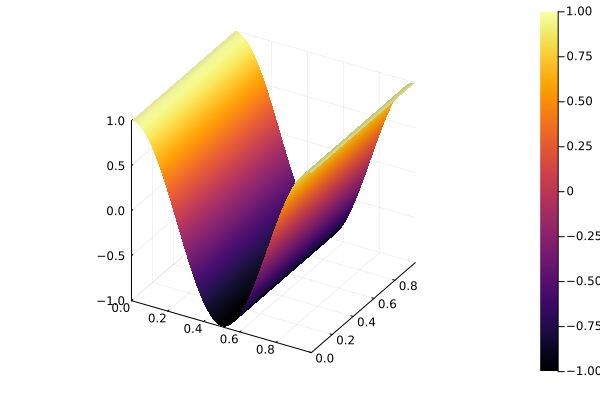

In [6]:
surface(yv,xv,V[2,:,:])

Plot initial magnetic field

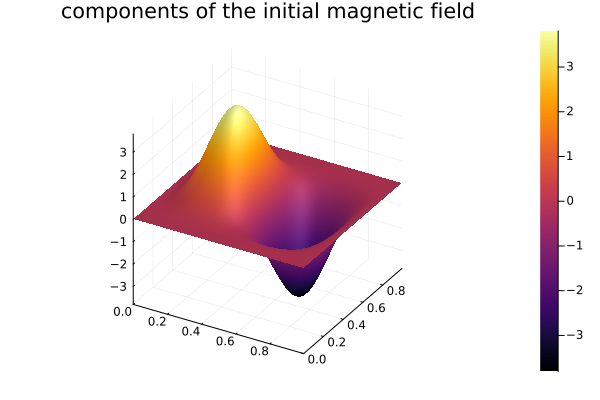

In [7]:
surface(yv,xv,B[1,:,:], title="components of the initial magnetic field")

Check the maximum initial constraint violation.

In [8]:
@show maximum(abs.(Div(B,Dx,Dy,J)))

maximum(abs.(Div(B, Dx, Dy, J))) = 9.271694523249607e-12


9.271694523249607e-12

Plot the initial constraint violation. Notice that it is of high frequency.

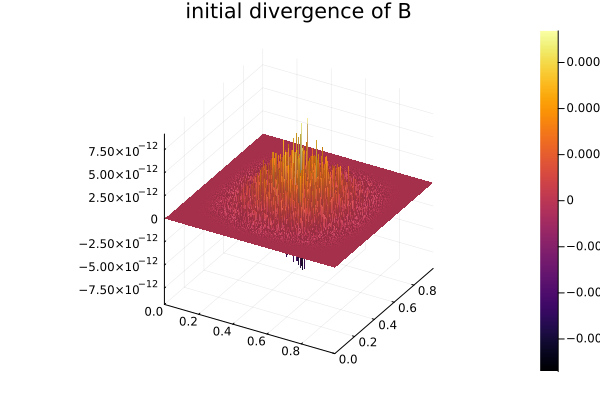

In [9]:
surface(yv,xv,Div(B,Dx,Dy,J), title="initial divergence of B")

Plot the divergence of the velocity field, some times it is important to see where the divergence of the magnetic field will grow.

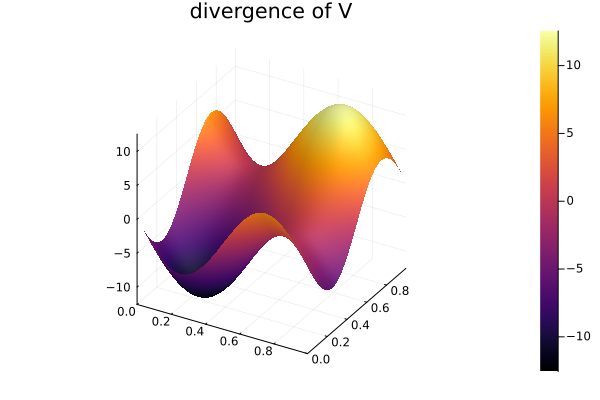

In [10]:
surface(yv,xv,Div(V,Dx,Dy,J), title="divergence of V")

Create the union of evolutionary fields. And location for its time derivatives.

In [ ]:
u = Vector{Float64}(undef,(D+1)*J[1]*J[2]); #the last component is psi
du = Vector{Float64}(undef,(D+1)*J[1]*J[2]);

u .= 0.0;
du .= 0.0;

U = reshape(u,D+1,J[1],J[2]);

3×200×250 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 248] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0

### Set the method:

In [69]:
#=
hyperbolic = false
parabolic = false
no_div_cleaning = false
hyperbolic = true
#parabolic = true
no_div_cleaning = true
=#
#method = :hyperbolic
#method = :parabolic
method = :no_div_cleaning
@show method

methods = [:no_div_cleaning, :hyperbolic, :parabolic]#, :mixed]

method = :no_div_cleaning


3-element Vector{Symbol}:
 :no_div_cleaning
 :hyperbolic
 :parabolic

In [80]:
function evolve(u,du,V, B_init, method, time_interval, M, par)
    J, Dx, Δx, Dy, Δy, σx, σy, V, κ, c2, τ, du = par
    U[1:D,:,:] .= copy(B_init)
    U[D+1,:,:] .= 0.0 #psi

    if method == :hyperbolic
        κ = 0.0
        c2 = 1.0
        τ = 1.0
    elseif method == :parabolic
        κ = minimum(dx)/2
        c2 = 0.0
        τ = 0.0
    elseif method == :no_div_cleaning
        κ = 0.0
        c2 = 0.0
        τ = 0.0
    elseif method == :mixed
        κ = 1.0
        c2 = 1.0
        τ = 1.0
    else
        error("method must be :hyperbolic, :parabolic or :no_div_cleaning")
    end
    (t_i, t_f) = time_interval
    dt = (t_f - t_i)/M

    par = (J, Dx, Δx, Dy, Δy, σx, σy, V, κ, c2, τ, du)

    @show κ, c2, τ, dt/maximum(dx)
    #set initial values
    Energy = Array{Float64,1}(undef,M+1)
    Div_B_max = Array{Float64,1}(undef,M+1)
    Div_B_L2 = Array{Float64,1}(undef,M+1)
    tt = Array{Float64,1}(undef,M+1)
    @show Energy[1] = get_Energy(u,J,Box)
    @show Div_B_max[1] = maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J)))
    @show Div_B_L2[1] = norm(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))*sqrt(volume(Box)/prod(J))
    tt[1] = t_i
    t = t_i
    
    for i in 1:M
        if method == :hyperbolic || method == :no_div_cleaning
            RK4_Step!(F_hyp!, u, 0.0, dt, par)
        elseif method == :parabolic
            RK4_Step!(F_par!, u, 0.0, dt, par)
        end
        t = t + dt
        tt[i+1] = t
    
        Energy[i+1] = get_Energy(u,J,Box)
        Div_B_max[i+1] = maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J)))
        Div_B_L2[i+1] = norm(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))*sqrt(volume(Box)/prod(J))

        println("t = $t")
        println("Energy = $(get_Energy(u,J,Box))")
        println("DivB = $(maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))))")
    
end
    return u, Energy, Div_B_max, Div_B_L2, tt
end

evolve (generic function with 3 methods)

In [61]:
method = :hyperbolic
#method = :parabolic
#method = :no_div_cleaning
time_interval = (0.0, 0.2)
M = 40
u_final, Energy, Div_B_max, Div_B_L2, tt = evolve(u,du,V,B,method, time_interval, M,par)

(κ, c2, τ, dt / maximum(dx)) = (0.0, 1.0, 1.0, 1.0)
Energy[1] = get_Energy(u, J, Box) = 3.4863880879620543
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 9.271694523249607e-12
Div_B_L2[1] = norm(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J)) * sqrt(volume(Box) / prod(J)) = 9.040120354610424e-13
t = 0.005
Energy = 3.487534486405837
DivB = 9.303668946358812e-12
t = 0.01
Energy = 3.4909731214723165
DivB = 9.350742402602918e-12
t = 0.015
Energy = 3.496702309728605
DivB = 9.305001213988362e-12
t = 0.02
Energy = 3.5047192631466033
DivB = 9.287015600989434e-12
t = 0.025
Energy = 3.515020115520221
DivB = 9.360220931675656e-12
t = 0.030000000000000002
Energy = 3.527599959214125
DivB = 9.431344594190705e-12
t = 0.035
Energy = 3.542452892011849
DivB = 9.454881322312758e-12
t = 0.04
Energy = 3.5595720737692154
DivB = 9.456213589942308e-12
t = 0.045
Energy = 3.5789497925204232
DivB = 9.425793479067579e-12
t = 0.049999999999999996
Energy = 3.600577539

([0.07864033200171645, -0.07864022802889101, 0.0, 0.08278143864079715, -0.07898896021987502, 0.0, 0.08693960678886532, -0.07926863788877837, 0.0, 0.09111210383936147  …  0.0, 0.06607130121316585, -0.07385112105910523, 0.0, 0.07012119625981755, -0.0744378690512082, 0.0, 0.07419965882150978, -0.07493045580938464, 0.0], [3.4863880879620543, 3.487534486405837, 3.4909731214723165, 3.496702309728605, 3.5047192631466033, 3.515020115520221, 3.527599959214125, 3.542452892011849, 3.5595720737692154, 3.5789497925204232  …  4.5565775144808915, 4.625323388079826, 4.69616651912357, 4.76911534903653, 4.844180666669078, 4.9213757232543, 5.000716343623579, 5.082221033624101, 5.165911083714808, 5.251810668747901], [9.271694523249607e-12, 9.303668946358812e-12, 9.350742402602918e-12, 9.305001213988362e-12, 9.287015600989434e-12, 9.360220931675656e-12, 9.431344594190705e-12, 9.454881322312758e-12, 9.456213589942308e-12, 9.425793479067579e-12  …  9.765521724602877e-12, 9.801937039810582e-12, 9.806377931909

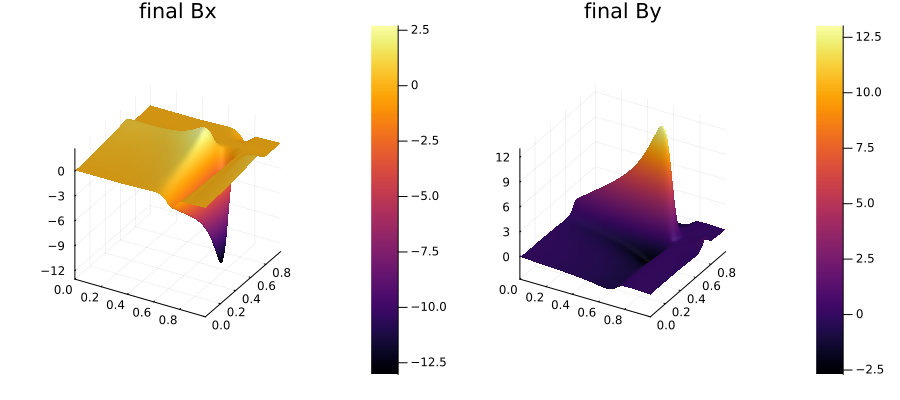

In [62]:
pBx = surface(yv,xv,reshape(u_final,(D+1,J...))[1,:,:], title="final Bx")
pBy = surface(yv,xv,reshape(u_final,(D+1,J...))[2,:,:], title="final By")

plot(pBx, pBy, size=(900,400))

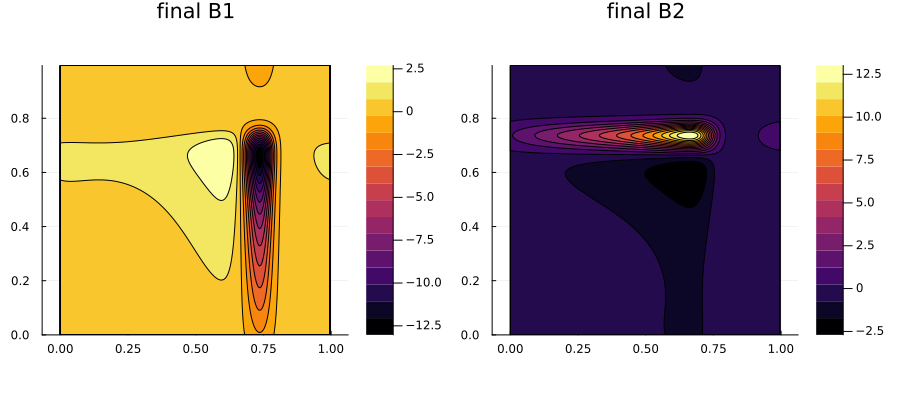

In [63]:
ps = []
for i in 1:2
    p1 = plot(yv, xv, reshape(u_final,(D+1,J...))[i,:,:], title="final B$i"
        ,linetype = :contourf
        #st = :surface,
        , aspect_ratio = 1)
    push!(ps, p1)
end

plot(ps[1], ps[2], layout = (1,2), size= (900,400))#linetype = :contourf, 
        

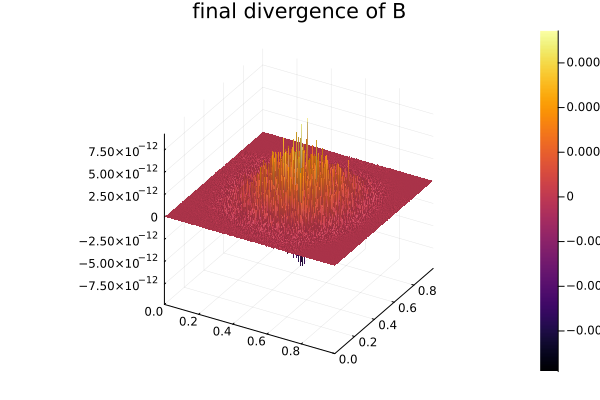

In [64]:
surface(yv,xv,Div(reshape(u_final,(D+1,J...))[1:D, :, :],Dx,Dy,J), title="final divergence of B")

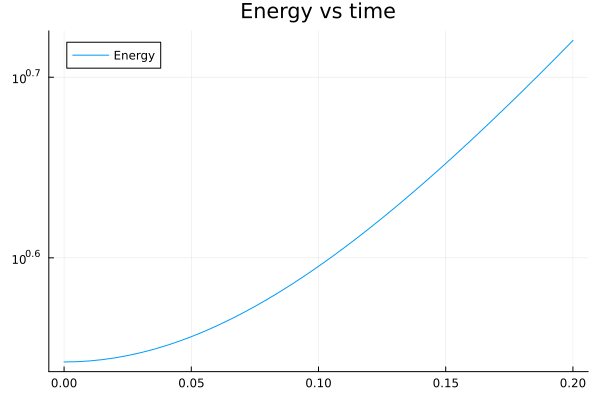

In [65]:
plot(tt,Energy, yaxis=:log, title="Energy vs time", label="Energy")

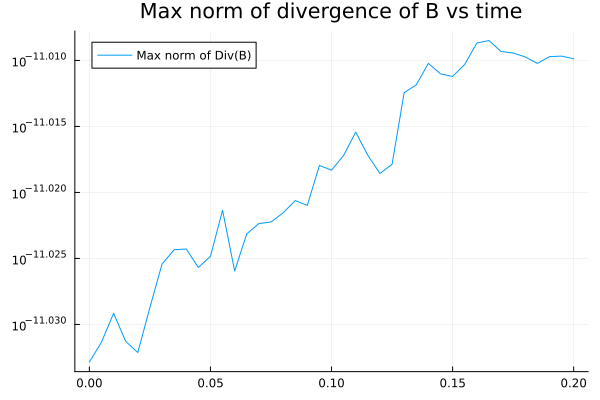

In [66]:
plot(tt, Div_B_max, yaxis=:log, title="Max norm of divergence of B vs time", label="Max norm of Div(B)")

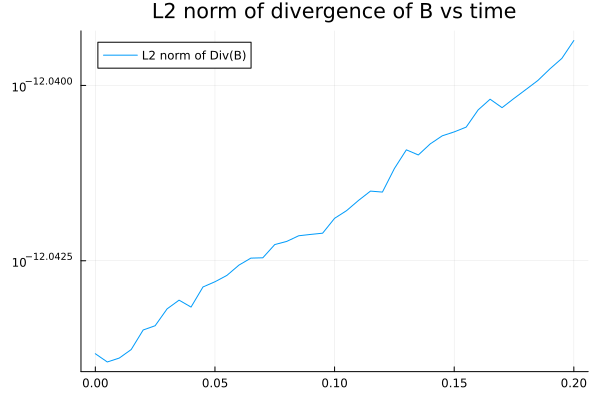

In [67]:
plot(tt, Div_B_L2, yaxis=:log, title="L2 norm of divergence of B vs time", label="L2 norm of Div(B)")

Evolving with method = no_div_cleaning
(κ, c2, τ, dt / maximum(dx)) = (0.0, 0.0, 0.0, 1.0)
Energy[1] = get_Energy(u, J, Box) = 3.4863880879620543
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 9.271694523249607e-12
Div_B_L2[1] = norm(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J)) * sqrt(volume(Box) / prod(J)) = 9.040120354610424e-13
t = 0.005
Energy = 3.487534486405837
DivB = 9.303668946358812e-12
t = 0.01
Energy = 3.4909731214723165
DivB = 9.350742402602918e-12
t = 0.015
Energy = 3.496702309728605
DivB = 9.305001213988362e-12
t = 0.02
Energy = 3.5047192631466033
DivB = 9.287015600989434e-12
t = 0.025
Energy = 3.515020115520221
DivB = 9.360220931675656e-12
t = 0.030000000000000002
Energy = 3.527599959214125
DivB = 9.431344594190705e-12
t = 0.035
Energy = 3.542452892011849
DivB = 9.454881322312758e-12
t = 0.04
Energy = 3.5595720737692154
DivB = 9.456213589942308e-12
t = 0.045
Energy = 3.5789497925204232
DivB = 9.425793479067579e-12
t = 0.

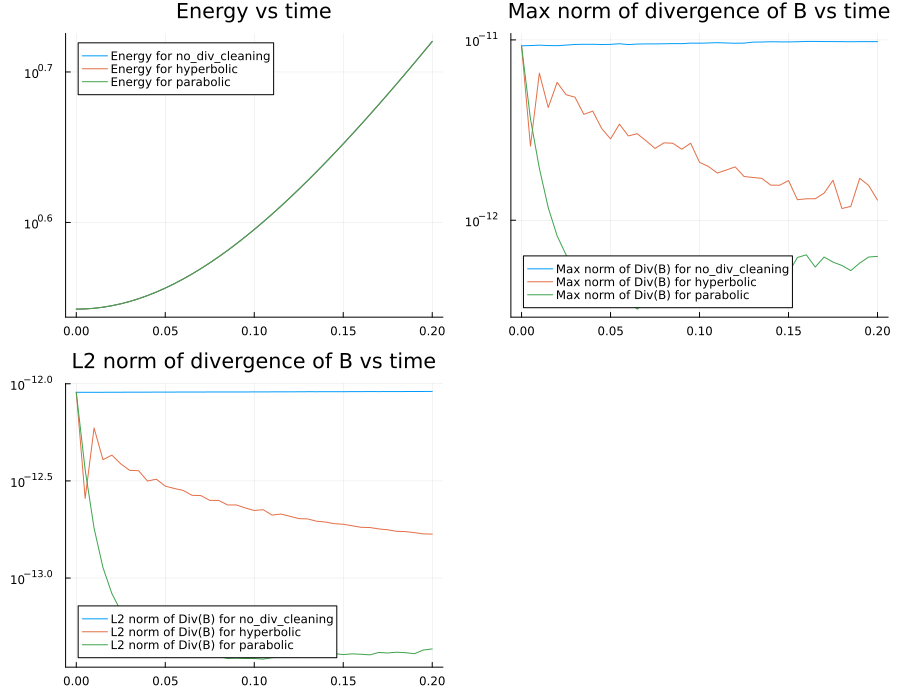

In [81]:
p_E = plot()
p_Div_max = plot()
p_Div_L2 = plot()

for method in methods
    println("Evolving with method = $method")
    u_final, Energy, Div_B_max, Div_B_L2, tt = evolve(u,du,V,B,method, time_interval, M,par)
    plot!(p_E,tt,Energy, yaxis=:log, title="Energy vs time", label="Energy for $method")
    plot!(p_Div_max,tt, Div_B_max, yaxis=:log, title="Max norm of divergence of B vs time", label="Max norm of Div(B) for $method")
    plot!(p_Div_L2,tt, Div_B_L2, yaxis=:log, title="L2 norm of divergence of B vs time", label="L2 norm of Div(B) for $method")
end

plot(p_E, p_Div_max, p_Div_L2, layout = (2,2), size=(900,700))

# Old material, superseeded

### Set the initial data.

B === (reshape(u, (D + 1, J...)))[1:D, :, :] = false
norm(B - (reshape(u, (D + 1, J...)))[1:D, :, :]) = 0.0
maximum(abs.(u)) = 3.8081748079221573
get_Energy(u, J, Box) = 3.4863880879620543
maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 9.271694523249607e-12
typeof(u) = Vector{Float64}
typeof(F_hyp!(u, 0.0, (J, Dx, Δx, Dy, Δy, σx, σy, V, 0.1, 1.0, 1.0, du))) = Vector{Float64}


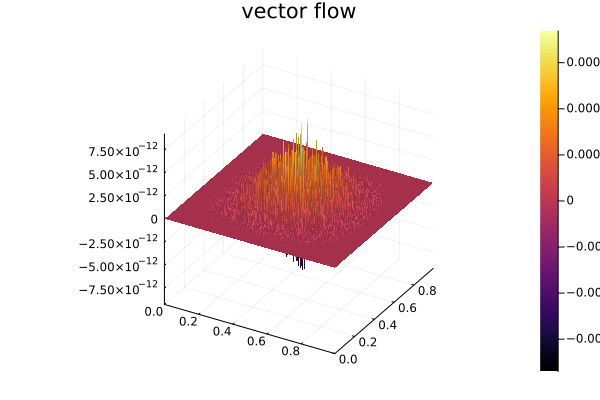

In [15]:
U[1:D,:,:] .= copy(B)
U[D+1,:,:] .= 0.0 #psi
@show B === reshape(u,(D+1,J...))[1:D,:,:]
@show norm(B - reshape(u,(D+1,J...))[1:D,:,:])
@show maximum(abs.(u))
@show get_Energy(u,J,Box)
@show maximum(abs.(Div(reshape(u,(D+1,J...))[1:D,:,:],Dx,Dy,J)))

@show typeof(u)
if method == :hyperbolic || method == :no_div_cleaning
@show typeof(F_hyp!(u,0.0,(J, Dx, Δx, Dy, Δy, σx, σy, V, 0.1, 1.0, 1.0, du)))
surface(yv,xv,reshape(F_hyp!(u,0.0,(J, Dx, Δx, Dy, Δy, σx, σy, zeros(D,J...), 0.1, 1, 1, du)),D+1,J...)[3,:,:], title="vector flow")
elseif method == :parabolic
@show typeof(F_par!(u,0.0,(J, Dx, Δx, Dy, Δy, σx, σy, V, 0.1, 1.0, 1.0, du)))
surface(yv,xv,reshape(F_hyp!(u,0.0,(J, Dx, Δx, Dy, Δy, σx, σy, zeros(D,J...), 0.1, 1, 1, du)),D+1,J...)[3,:,:], title="vector flow")
end
#surface(yv,xv,du[2,:,:])

### Set the evolution parameters:

In [16]:
(t_i, t_f) = (0.0, 0.2)
M = 40
@show dt = (t_f - t_i)/M
@show differentials(Box,J)

if method == :hyperbolic 
      κ = 0.0
      c2 = 1.0
      τ = 1.0
elseif method == :parabolic
      κ = maximum(dx) # we scale the dissipation with the grid size so that it does not changes the CFL factor.
      c2 = 0.0
      τ = 0.0
end

if method == :no_div_cleaning
      κ = 0.0
      c2 = 0.0
      τ = 0.0
end



@show κ, c2, τ
par = (J, Dx, Δx, Dy, Δy, σx, σy, V, κ, c2, τ, du)
t = t_i
Energy = Array{Float64,1}(undef,M+1)
Div_B_max = Array{Float64,1}(undef,M+1)
Div_B_L2 = Array{Float64,1}(undef,M+1)
tt = Array{Float64,1}(undef,M+1)
@show Energy[1] = get_Energy(u,J,Box)
@show Div_B_max[1] = maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J)))
@show Div_B_L2[1] = norm(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))*sqrt(volume(Box)/prod(J))
tt[1] = t;

dt = (t_f - t_i) / M = 0.005
differentials(Box, J) = [0.005, 0.004]
(κ, c2, τ) = (0.0, 0.0, 0.0)
Energy[1] = get_Energy(u, J, Box) = 3.4863880879620543
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 9.271694523249607e-12
Div_B_L2[1] = norm(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J)) * sqrt(volume(Box) / prod(J)) = 9.040120354610424e-13


In [17]:
@show κ, c2, τ, dt/maximum(dx)

(κ, c2, τ, dt / maximum(dx)) = (0.0, 0.0, 0.0, 1.0)


(0.0, 0.0, 0.0, 1.0)

In [18]:
for i in 1:M
    if method == :hyperbolic || method == :no_div_cleaning
        RK4_Step!(F_hyp!, u, 0.0, dt, par)
    elseif method == :parabolic
        RK4_Step!(F_par!, u, 0.0, dt, par)
    end
    t = t + dt
    tt[i+1] = t
    
    Energy[i+1] = get_Energy(u,J,Box)
    Div_B_max[i+1] = maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J)))
    Div_B_L2[i+1] = norm(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))*sqrt(volume(Box)/prod(J))

    println("t = $t")
    println("Energy = $(get_Energy(u,J,Box))")
    println("DivB = $(maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))))")
    
end

t = 0.005
Energy = 3.487534486405837
DivB = 9.303668946358812e-12
t = 0.01
Energy = 3.4909731214723165
DivB = 9.350742402602918e-12
t = 0.015
Energy = 3.496702309728605
DivB = 9.305001213988362e-12
t = 0.02
Energy = 3.5047192631466033
DivB = 9.287015600989434e-12
t = 0.025
Energy = 3.515020115520221
DivB = 9.360220931675656e-12
t = 0.030000000000000002
Energy = 3.527599959214125
DivB = 9.431344594190705e-12
t = 0.035
Energy = 3.542452892011849
DivB = 9.454881322312758e-12
t = 0.04
Energy = 3.5595720737692154
DivB = 9.456213589942308e-12
t = 0.045
Energy = 3.5789497925204232
DivB = 9.425793479067579e-12
t = 0.049999999999999996
Energy = 3.6005775396294335
DivB = 9.444001136671432e-12
t = 0.05499999999999999
Energy = 3.624446093528968
DivB = 9.520384480765642e-12
t = 0.05999999999999999
Energy = 3.6505456115440786
DivB = 9.420020319339528e-12
t = 0.06499999999999999
Energy = 3.6788657292571942
DivB = 9.481304630298837e-12
t = 0.06999999999999999
Energy = 3.7093956668372425
DivB = 9.49818

In [20]:
#It works in Paraview but not in VisIt
vtk_grid("u", xv, yv) do vtk
    vtk["B"] = @views reshape(u,(D+1,J...))[1:D, :, :]        # Magnetic field attached to points
    vtk["ψ"] = @views reshape(u,(D+1,J...))[3, :, :]     # scalar field attached to cells
    vtk["Velocity"] = V            # vector field attached to points
    vtk["TimeValue"] = tt[M+1]                           # metadata ("field data" in VTK)
end

1-element Vector{String}:
 "u.vtr"

The ψ field:

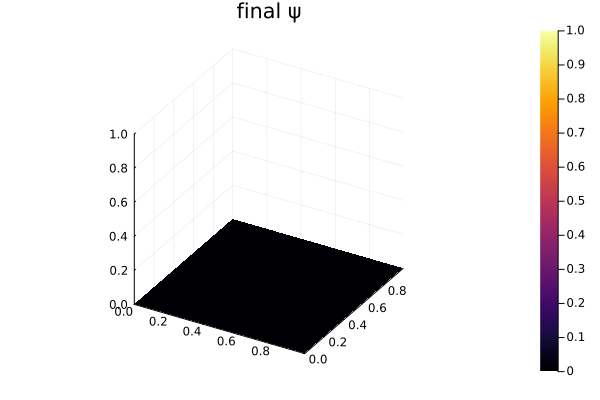

In [32]:
surface(yv,xv,reshape(u,(D+1,J...))[3, :, :], title="final ψ")

The magnetic field:

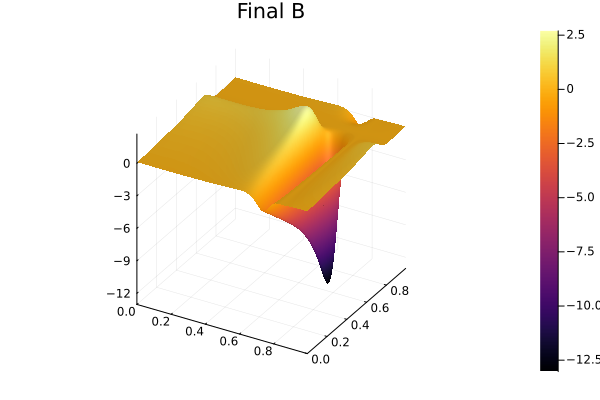

In [33]:
surface(yv,xv,reshape(u_final,(D+1,J...))[1, :, :], title="Final B")

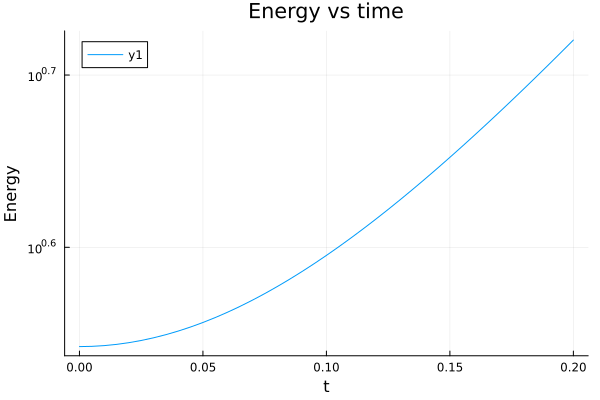

In [34]:
plot(tt, Energy, yscale=:log10, title="Energy vs time", xlabel="t", ylabel="Energy")

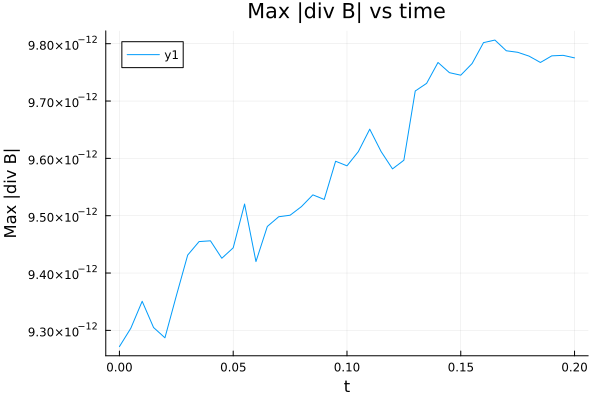

In [35]:
plot(tt, Div_B_max,title="Max |div B| vs time",xlabel="t",ylabel="Max |div B|")

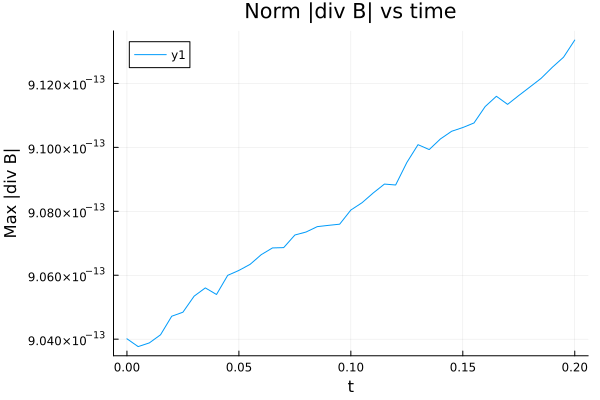

In [36]:
plot(tt, Div_B_L2,title="Norm |div B| vs time",xlabel="t",ylabel="Max |div B|")

### Comparison:

We compare both cleaning methods against themselves and the free, no-cleaning evolution.

In [26]:

if method == :no_div_cleaning 
    Div_B_max_0 = copy(Div_B_max); #for no div control.
    Div_B_L2_0 = copy(Div_B_L2);
else
    if method == :hyperbolic
        Div_B_max_1_1 = copy(Div_B_max);
        Div_B_L2_1_1 = copy(Div_B_L2);
    elseif method == :parabolic
        Div_B_max_1 = copy(Div_B_max);
        Div_B_L2_1 = copy(Div_B_L2);
    end
end


41-element Vector{Float64}:
 9.040120354610424e-13
 9.037676281738249e-13
 9.03883354451428e-13
 9.041368797852525e-13
 9.047174787372847e-13
 9.048436058168373e-13
 9.053450025495613e-13
 9.056038955235428e-13
 9.053979117301548e-13
 9.059964550561446e-13
 ⋮
 9.112780227992815e-13
 9.115985070614925e-13
 9.113458524749686e-13
 9.116227332491864e-13
 9.11890744447685e-13
 9.121615114583525e-13
 9.125072275622193e-13
 9.128216966394244e-13
 9.133571951687479e-13

We observe that in $L^2$ norm both the non-cleaning and the hyperbolic methods grow. The hyperbolic does a good job in holding the violation small. But the parabolic methods works much better, keeping the violation to a better level than what it was originally. 
If we increase the τ value to 100 then the hyperbolic method works in a very similar way as the parabolic one. 

**Warning:** in these simulations the magnetic field evolves very high frequencies very quickly and already the last part of the computation does not resolves the solution very well. Even though the constraint violation stays small.

In [27]:
plot(tt,Div_B_L2_0, title="Norm |div B| vs time D-order=4",xlabel="t",ylabel="Norm |div B|", label="κ=0.0, c2 = 0.0, τ = 0.0", yscale=:log10)
plot!(tt,Div_B_L2_1_1, label="κ = 0.0, c2=1, τ=100")
plot!(tt,Div_B_L2_1, label="κ=1, c2= 0.0, τ=0")
#savefig("DivB_L2_vs_time_D-order=4_bump_neg_tau100.png")

UndefVarError: UndefVarError: `Div_B_L2_1_1` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

![DivB_L2_vs_time](DivB_L2_vs_time_D-order=4_bump_neg.png)
![DivB_L2_vs_time](DivB_L2_vs_time_D-order=4_bump_neg_tau100.png)

In the maximum norm we observe something similar. 

In [28]:
plot(tt,Div_B_max_0, title="Max |div B| vs time D-order=4",xlabel="t",ylabel="Max |div B|", label="c2=0.0", yscale=:log10)
plot!(tt,Div_B_max_1_1, label="c2=1 τ=100")
plot!(tt,Div_B_max_1, label="κ=1 τ=0")
#savefig("DivB_max_vs_time_D-order_bump_neg_tau100=4.png")

UndefVarError: UndefVarError: `Div_B_max_1_1` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

![DivB_max_vs_time](DivB_max_vs_time_D-order_bump_neg=4.png)
![DivB_max_vs_time](DivB_max_vs_time_D-order_bump_neg_tau100=4.png)
